In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table

%matplotlib notebook

In [116]:
ps1_white_phot = fits.getdata("COSMOS_compare_white_phot_adamamiller.fit")

The first step is to create some filters so that apples to apples comparisons can be done between the 3 different photometry methods from PS1.

In [117]:
print("Of the {:d} unique sources in the COSMOS cross-match:".format(len(ps1_white_phot)))
print("\tThere are {:d} sources with Mean white phot,".format(sum(~np.isnan(ps1_white_phot["wwMeanPSFKronRatio"]))))
print("\tThere are {:d} sources with Forced white phot,".format(sum(~np.isnan(ps1_white_phot["wwFPSFKronRatio"]))))
print("\tThere are {:d} sources with Stacked white phot.".format(sum(~np.isnan(ps1_white_phot["wwPSFKronRatio"]))))

Of the 80974 unique sources in the COSMOS cross-match:
	There are 42784 sources with Mean white phot,
	There are 80880 sources with Forced white phot,
	There are 76083 sources with Stacked white phot.


In [137]:
det_mfs = np.where(np.isfinite(ps1_white_phot["wwMeanPSFKronRatio"]) & 
                   np.isfinite(ps1_white_phot["wwFPSFKronRatio"]) & 
                   np.isfinite(ps1_white_phot["wwPSFKronRatio"]))
det_mfs_star = np.where(np.isfinite(ps1_white_phot["wwMeanPSFKronRatio"]) & 
                        np.isfinite(ps1_white_phot["wwFPSFKronRatio"]) & 
                        np.isfinite(ps1_white_phot["wwPSFKronRatio"]) & 
                        (ps1_white_phot["mu_class"] == 2) &
                        (ps1_white_phot["wwMeanPSFKronRatio"] <= 2.0))
det_mfs_gal = np.where(np.isfinite(ps1_white_phot["wwMeanPSFKronRatio"]) & 
                        np.isfinite(ps1_white_phot["wwFPSFKronRatio"]) & 
                        np.isfinite(ps1_white_phot["wwPSFKronRatio"]) & 
                        (ps1_white_phot["mu_class"] == 1) &
                        (ps1_white_phot["wwMeanPSFKronRatio"] <= 2.0))
det_fs = np.where(np.isfinite(ps1_white_phot["wwFPSFKronRatio"]) & 
                  np.isfinite(ps1_white_phot["wwPSFKronRatio"]))

/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in less_equal
/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in less_equal


## Plot distance vs. Kron mag for 3 different phot measures

Show the distribution of these sources in their respective PSF vs. Kron planes.

In [52]:
import seaborn as sns

In [323]:
ps1_df = Table.read("COSMOS_compare_white_phot_adamamiller.fit").to_pandas()

ps1_df["MeanDist"] = (ps1_white_phot["wwMeanPSFFlux"] - ps1_white_phot["wwMeanKronFlux"])/np.sqrt(2)
ps1_df["FDist"] = (ps1_white_phot["wwFPSFFlux"] - ps1_white_phot["wwFKronFlux"])/np.sqrt(2)
ps1_df["Dist"] = (ps1_white_phot["wwPSFFlux"] - ps1_white_phot["wwKronFlux"])/np.sqrt(2)

ps1_df["MeanKronMag"] = -2.5*np.log10(ps1_white_phot["wwMeanKronFlux"]/3631)
ps1_df["FKronMag"] = -2.5*np.log10(ps1_white_phot["wwFKronFlux"]/3631)
ps1_df["KronMag"] = -2.5*np.log10(ps1_white_phot["wwKronFlux"]/3631)


In [327]:
from statsmodels.nonparametric.kernel_density import KDEMultivariate
import statsmodels.nonparametric.api as smnp

def kde_contour_dat(x, y, extent = (0,0,0,0), bw_type = "silverman", grid_bins = 100):
    """Determine normalized KDE PDF to draw contours"""
    
    if isinstance(x, pd.Series):
        x = x.values
    if isinstance(y, pd.Series):
        y = y.values
    
    if extent == (0,0,0,0):
        extent = (x.min(), x.max(), y.min(), y.max())

    if bw_type == "silverman":
        bw = np.array([smnp.bandwidths.bw_silverman(x), smnp.bandwidths.bw_silverman(y)])
    elif bw_type == "scott":
        bw = np.array([smnp.bandwidths.bw_scott(x), smnp.bandwidths.bw_scott(y)])

    kde = KDEMultivariate([x,y], var_type='cc', bw = bw)

    xi, yi = np.mgrid[extent[0]:extent[1]:grid_bins*1j,extent[2]:extent[3]:grid_bins*1j]

    kde_prob = kde.pdf(np.vstack([xi.flatten(), yi.flatten()]))

    zi = (kde_prob-kde_prob.min())/(kde_prob.max() - kde_prob.min())
    zi = zi.reshape(xi.shape)

    return xi, yi, zi

In [ ]:
gal_dist_mean = ps1_df.ix[det_mfs_gal]["MeanDist"]
gal_mag_mean = ps1_df.ix[det_mfs_gal]["MeanKronMag"]

star_dist_mean = ps1_df.ix[det_mfs_star]["MeanDist"]
star_mag_mean = ps1_df.ix[det_mfs_star]["MeanKronMag"]

xgal_mean, ygal_mean, zgal_mean = kde_contour_dat(gal_mag_mean, gal_dist_mean, extent = (16,24,-2e-5,2e-5))
xstar_mean, ystar_mean, zstar_mean = kde_contour_dat(star_mag_mean, star_dist_mean, extent = (16,24,-2e-5,2e-5))

gal_dist_forced = ps1_df.ix[det_mfs_gal]["FDist"]
gal_mag_forced = ps1_df.ix[det_mfs_gal]["FKronMag"]

star_dist_forced = ps1_df.ix[det_mfs_star]["FDist"]
star_mag_forced = ps1_df.ix[det_mfs_star]["FKronMag"]

xgal_forced, ygal_forced, zgal_forced = kde_contour_dat(gal_mag_forced, gal_dist_forced, extent = (16,24,-2e-5,2e-5))
xstar_forced, ystar_forced, zstar_forced = kde_contour_dat(star_mag_forced, star_dist_forced, extent = (16,24,-2e-5,2e-5))

gal_dist_stacked = ps1_df.ix[det_mfs_gal]["Dist"]
gal_mag_stacked = ps1_df.ix[det_mfs_gal]["KronMag"]

star_dist_stacked = ps1_df.ix[det_mfs_star]["Dist"]
star_mag_stacked = ps1_df.ix[det_mfs_star]["KronMag"]

xgal_stacked, ygal_stacked, zgal_stacked = kde_contour_dat(gal_mag_stacked, gal_dist_stacked, extent = (16,24,-2e-5,2e-5))
xstar_stacked, ystar_stacked, zstar_stacked = kde_contour_dat(star_mag_stacked, star_dist_stacked, extent = (16,24,-2e-5,2e-5))

<IPython.core.display.Javascript object>


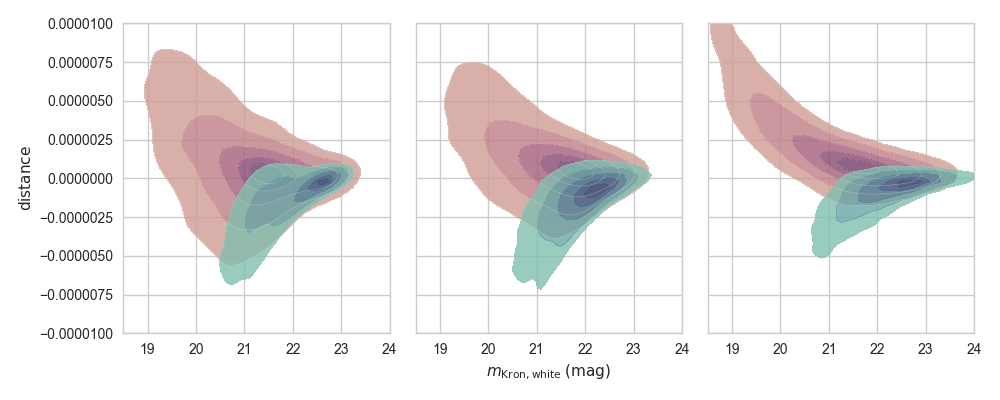

In [340]:
origin = 'lower'
levels = [0.1, 0.25, 0.5, 0.75, 0.9,1]
cmap_star = sns.cubehelix_palette(rot=0.5, light=0.7,dark=0.3,as_cmap=True)
cmap_gal = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)

with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize = (10, 4))
    for axnum, (xstar, ystar, zstar, xgal, ygal, zgal) in enumerate([(xstar_mean, ystar_mean, zstar_mean, xgal_mean, ygal_mean, zgal_mean), 
                                                                     (xstar_forced, ystar_forced, zstar_forced, xgal_forced, ygal_forced, zgal_forced), 
                                                                     (xstar_stacked, ystar_stacked, zstar_stacked,xgal_stacked, ygal_stacked, zgal_stacked)]):
        axes[axnum].contourf(xstar, ystar, zstar, levels = levels,
                             origin = origin,
                             cmap = cmap_star, alpha = 0.8)
        axes[axnum].contour(xstar, ystar, zstar, levels = levels,
                            linewidths=(0.3,), origin = origin,
                            colors = ("w",), alpha = 0.5, zorder = 11)
        axes[axnum].contourf(xgal, ygal, zgal, levels = levels,
                             origin = origin, 
                             cmap = cmap_gal, alpha = 0.8, zorder = 10)
        axes[axnum].contour(xgal, ygal, zgal, levels = levels,
                            linewidths=(0.5,), origin = origin, 
                            colors = ("w",), alpha = 0.5)

    axes[axnum].set_xlim(18.5, 24)
    axes[axnum].set_ylim(-1e-5, 1e-5)
    axes[1].set_xlabel(r"$m_\mathrm{Kron,white}\;(\mathrm{mag})$")
    axes[0].set_ylabel(r"$\mathrm{distance}$")
    fig.tight_layout()

## Determine the combo of data + slope to maximize TPR at FPR = 0.005